# Anomaly Detection with different models

### this is a notebook that tries to learn staff behaviours from train data with different models and different features.

Section that are included

*   Importing, installing and loading necessaries
*   Feature Engineering
*   Autoencoder to Catch Abnormal Users
*   Isolation Forest to Catch Abnormal Rows



## 1.Importing, Installing and Loading Necessaries

Datasets generated synthetically by simulating realistic log datas and converting them into tables. After generating tables, data converted into numeric values to get better results. Vectorization is also tried but numerical approach gets better results. Maybe, later on, vectorized approach could be tried again.
<br>
<br>
If you are curious about preprocessing or other studies search it on:
<br>
[Project Repo](https://github.com/sabisay/AnomalyDetectionOnLogDatas)

* Its all starts from here:

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

* scikit-learn, keras, matplotlib, seaborn; adds visualization, simplest ways to use models, algorithms and build neural networks:

In [2]:
# visuals
import matplotlib.pyplot as plt
import seaborn as sns
# data scaling or calculating metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Building Neural Network
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [3]:
import matplotlib.pyplot as plt # to show visuals on notebook

from google.colab import drive # to load dataset to github
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from tensorflow.keras.regularizers import l2

* Loading dataset from github:


In [6]:
# Dictionary with dataset names and their raw GitHub URLs
datasets = {
    "TrainSet": "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/TrdTry/df_train.csv",
    "CVSet": "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/TrdTry/df_cv.csv",
    "TestSet": "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/TrdTry/df_test.csv",
}

# Load datasets seperately
df_train = pd.read_csv(datasets["TrainSet"])
df_cv = pd.read_csv(datasets["CVSet"])
df_test = pd.read_csv(datasets["TestSet"])

In [7]:
# This datasets for comparing predicted labels and real labels

datasets_2 = {
    "cv_labeled" : "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/TrdTry/df_labeled_cv.csv",
    "test_labeled" : "https://raw.githubusercontent.com/sabisay/AnomalyDetectionOnLogDatas/refs/heads/main/DatasetsAfterPreprocess/TrdTry/df_labeled_test.csv"
}

df_cv_labeled = pd.read_csv(datasets_2["cv_labeled"])
df_test_labeled = pd.read_csv(datasets_2["test_labeled"])

## 2.Feature Engineering

* We need to analyze user behaviours accoring to that log datas. So, we are creating generalized behavioural analysis dataset.

In [8]:
def generate_user_behavior_vectors(df, timestamp_col="Timestamp", user_col="UserID"):

    # Hazırlıklar
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df["Date"] = df[timestamp_col].dt.date
    df["Hour"] = df[timestamp_col].dt.hour

    # VPN / Onsite bağlantı oranı
    def vpn_ratio(x):
        return (x == 0).mean()

    df["IsNight"] = df["Hour"].apply(lambda h: 1 if (h < 7 or h >= 20 or h == 0) else (0 if 9 <= h <= 17 else None))


    # shift_logic hesaplama
    def calculate_shift_logic(group):
        total_logs = len(group)
        night_logs = group["IsNight"].sum()
        day_logs = total_logs - night_logs
        night_ratio = night_logs / total_logs
        day_ratio = day_logs / total_logs
        return min(night_ratio, day_ratio)

    # Gruplama
    grouped = df.groupby([user_col, "Date"])

    # Özellik mühendisliği (std_hour çıkarıldı)
    session_vectors = grouped.agg(
        total_logs=("ID", "count"),
        mean_duration=("AccessDuration", "mean"),
        fail_ratio=("IsAccessFail", "mean"),
        sensitive_ratio=("IsSensitive", "mean"),
        vpn_ratio=("Connection", vpn_ratio),
        unique_patient_count=("PatientID", pd.Series.nunique),
        unique_device_count=("DeviceID", pd.Series.nunique),
        shift_logic=("IsNight", lambda x: calculate_shift_logic(x.to_frame().join(df.loc[x.index, ["Hour"]])))
    ).fillna(0).reset_index()

    return session_vectors


In [9]:
train_df = generate_user_behavior_vectors(df_train)
validation_df = generate_user_behavior_vectors(df_cv)
test_df = generate_user_behavior_vectors(df_test)

In [10]:
test_df.head(10)

,UserID,Date,total_logs,mean_duration,fail_ratio,sensitive_ratio,vpn_ratio,unique_patient_count,unique_device_count,shift_logic
0,1,2024-01-01,36,214.888889,0.027778,0.166667,1.0,36,35,0.0
1,1,2024-01-02,41,192.487805,0.024390,0.292683,1.0,41,38,0.0
2,1,2024-01-03,31,217.903226,0.000000,0.290323,1.0,30,27,0.0
3,2,2024-01-01,35,203.457143,0.000000,0.257143,1.0,35,32,0.0
4,2,2024-01-02,31,207.225806,0.000000,0.161290,1.0,31,30,0.0
5,2,2024-01-03,37,197.648649,0.027027,0.216216,1.0,37,33,0.0
6,3,2024-01-01,39,209.564103,0.000000,0.282051,1.0,39,38,0.0
7,3,2024-01-02,33,204.848485,0.030303,0.272727,1.0,33,30,0.0
8,3,2024-01-03,32,191.656250,0.062500,0.218750,1.0,32,29,0.0
9,4,2024-01-01,30,191.333333,0.000000,0.166667,1.0,30,28,0.0


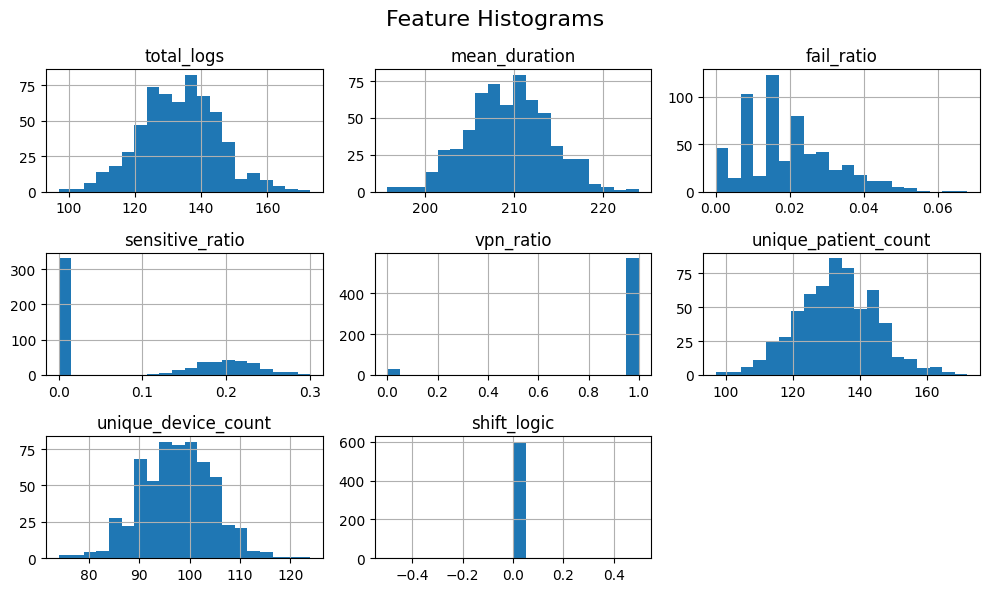

In [11]:
# Özellik sütunları (ID, UserID ve Date dışındaki her şey)
feature_cols = [
    'total_logs', 'mean_duration', 'fail_ratio', 'sensitive_ratio',
    'vpn_ratio', 'unique_patient_count', 'unique_device_count', 'shift_logic'
]
# Histogramlar
train_df[feature_cols].hist(bins=20, figsize=(10, 6), layout=(3, 3))
plt.suptitle("Feature Histograms", fontsize=16)
plt.tight_layout()
plt.show()

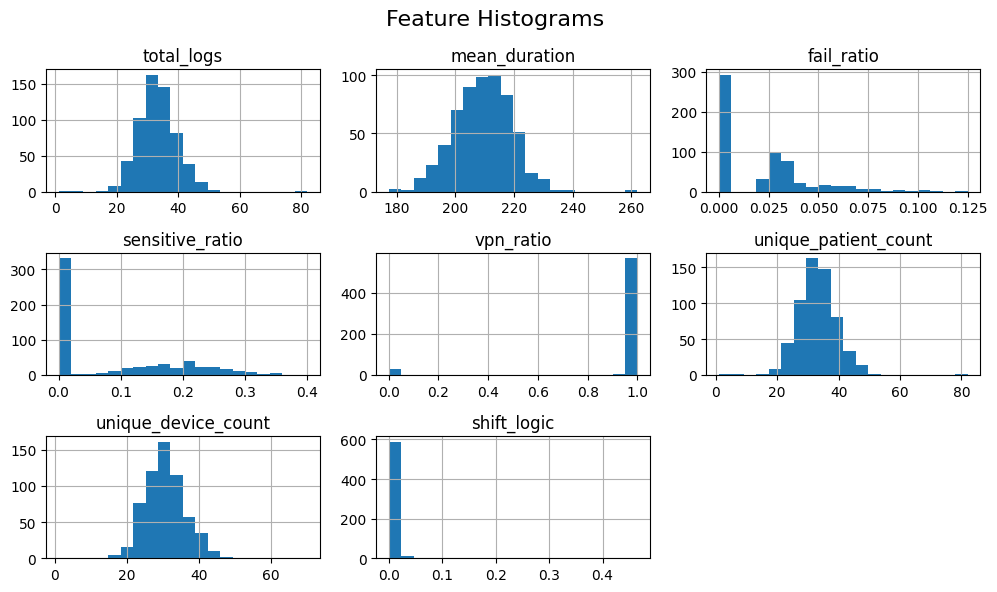

In [12]:
# Histogramlar
validation_df[feature_cols].hist(bins=20, figsize=(10, 6), layout=(3, 3))
plt.suptitle("Feature Histograms", fontsize=16)
plt.tight_layout()
plt.show()

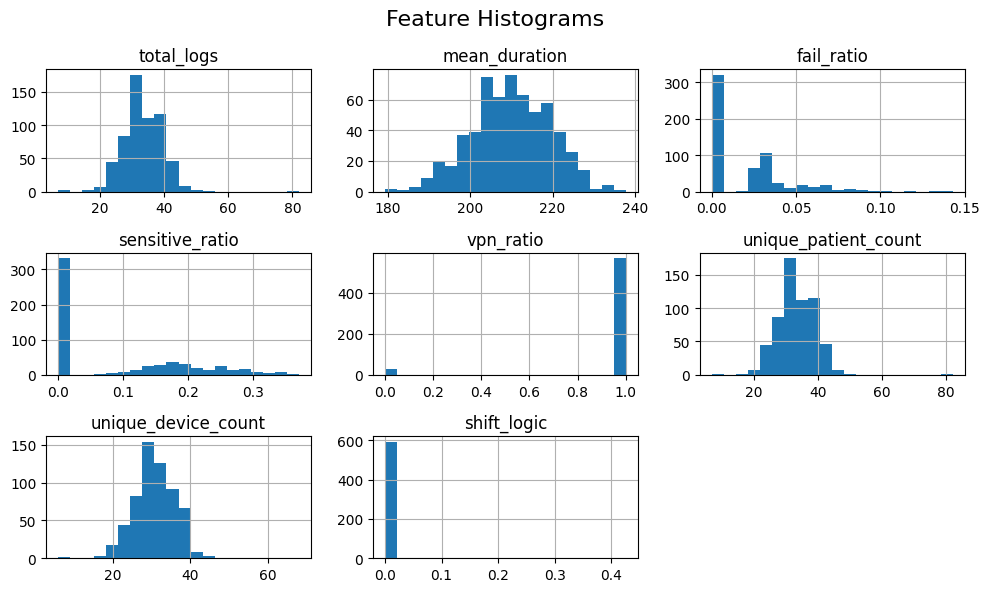

In [13]:
# Histogramlar
test_df[feature_cols].hist(bins=20, figsize=(10, 6), layout=(3, 3))
plt.suptitle("Feature Histograms", fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
def plot_behavior_heatmap(behavior_df, title="Behavior Feature Correlation Heatmap"):
    # Sadece sayısal kolonları al
    numeric_df = behavior_df.select_dtypes(include=["float64", "int64"])

    # Korelasyon matrisini hesapla
    corr = numeric_df.corr()

    # Heatmap çiz
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5)
    plt.title(title)
    plt.tight_layout()
    plt.show()


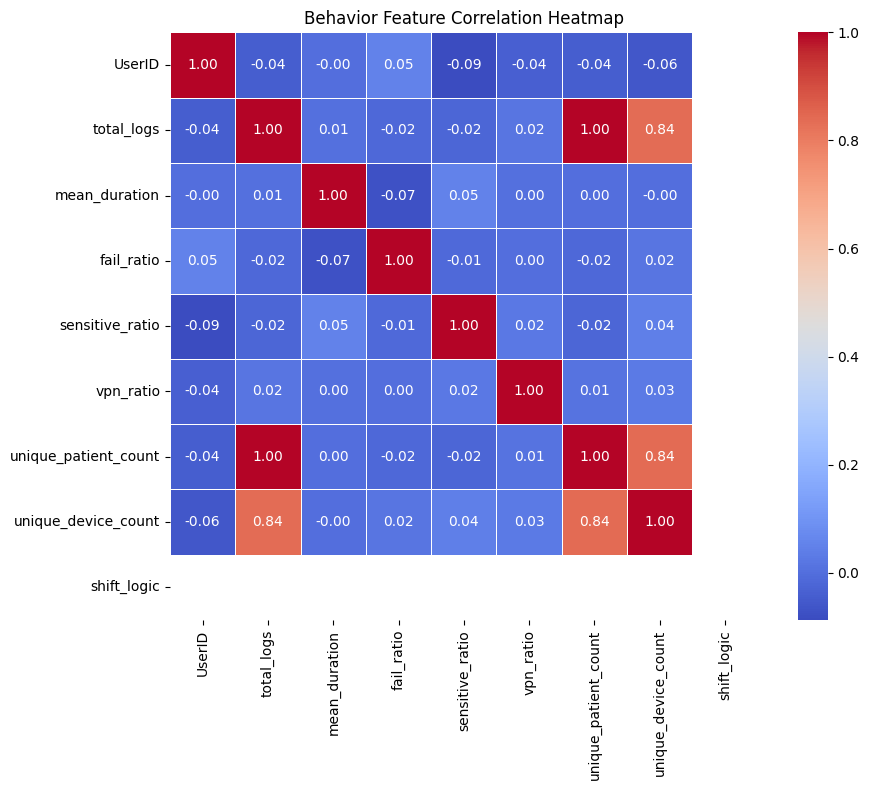

In [15]:
plot_behavior_heatmap(train_df)

* Feature matrix that is gonna used on model:

In [16]:
# Feature matrix
X_train = train_df.drop(columns=["UserID", "Date"])
X_val = validation_df.drop(columns=["UserID", "Date"])
X_test = test_df.drop(columns=["UserID", "Date"])

* Scaler:

In [17]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [18]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

* Defining Model:

In [19]:
# 🤖 Build Autoencoder
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)

input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu', activity_regularizer=l2(1e-4))(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(8, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, output_layer)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560 (2.19 KB)

 Trainable params: 560 (2.19 KB)

 Non-trainable params: 0 (0.00 B)

* Model Compilation:

In [20]:
autoencoder.compile(optimizer='adam', loss='mse')


history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stop]
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9621 - val_loss: 1.0134
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9151 - val_loss: 0.9867
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8908 - val_loss: 0.9602
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8669 - val_loss: 0.9291
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8344 - val_loss: 0.8921
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7972 - val_loss: 0.8541
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7616 - val_loss: 0.8161
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7274 - val_loss: 0.7781
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6968 - val_loss: 0.7326
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6394 - val_loss: 0.6769
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5786 - val_loss: 0.6156
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5347 -

* Train - Validation Loss:

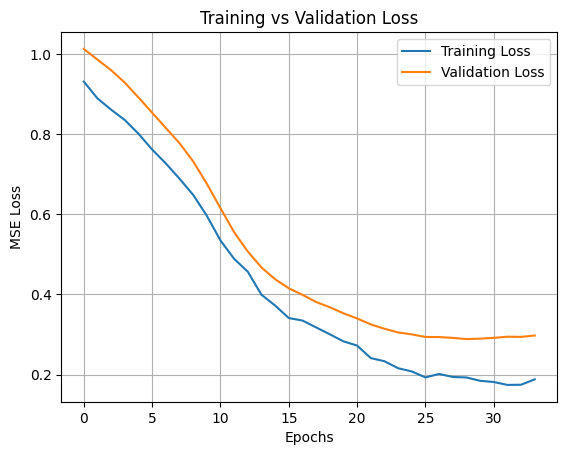

In [21]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

* Reconstruction to calculate error



In [22]:
# 📊 Evaluate reconstruction error (for Dense Autoencoder)
def get_reconstruction_error(data):
    recon = autoencoder.predict(data)
    return np.mean(np.square(data - recon), axis=1)  # sadece feature boyutunda hata

# 🚧 Error hesaplama
train_error = get_reconstruction_error(X_train)
threshold = np.percentile(train_error, 99)

cv_error = get_reconstruction_error(X_val)
test_error = get_reconstruction_error(X_test)



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [23]:
# 📌 Anomali tahmini
cv_pred = (cv_error > threshold).astype(int)
test_pred = (test_error > threshold).astype(int)

print(f"Anomali eşik değeri (99.98 percentiles): {threshold:.6f}")
print(f"Detected {np.sum(cv_pred)} anomalies out of {len(cv_error)} CV sequences.")
print(f"Detected {np.sum(test_pred)} anomalies out of {len(test_error)} test sequences.")

Anomali eşik değeri (99.98 percentiles): 0.452005
Detected 23 anomalies out of 600 CV sequences.
Detected 17 anomalies out of 600 test sequences.


In [32]:
import plotly.express as px

# Örnek veri: CV seti
# user_ids: kullanıcı kimlikleri ile dolu NumPy array ya da liste olmalı
# cv_error: her kullanıcıya ait rekonstrüksiyon hataları
# cv_pred: her kullanıcı için 1 (anomali) ya da 0 (normal)
# threshold: anomali eşiği

# Rastgele hafif jitter ekleyelim (±0.2 arası)
jittered_indices = np.arange(len(cv_error)) + np.random.uniform(-0.2, 0.2, len(cv_error))
user_ids = validation_df["UserID"].values;

# DataFrame oluştur
df = pd.DataFrame({
    "Index": jittered_indices,
    "User ID": user_ids,
    "Error Score": cv_error,
    "Anomaly Label": np.where(cv_pred == 1, "Anomalous", "Normal")
})

# Plotly scatter plot
fig = px.scatter(
    df,
    x="Index",
    y="Error Score",
    color="Anomaly Label",
    title="📊 CV Seti - Anomali Dağılımı (Interaktif)",
    labels={"Index": "Kullanıcı Sırası", "Error Score": "Rekonstrüksiyon Hatası"},
    color_discrete_map={"Anomalous": "red", "Normal": "blue"},
    hover_data={"User ID": True, "Error Score": True, "Anomaly Label": True}
)

# Eşik çizgisi
fig.add_hline(
    y=threshold,
    line_dash="dash",
    line_color="green",
    annotation_text="Threshold",
    annotation_position="top left"
)

fig.update_layout(hovermode="closest", height=500)
fig.show()


In [25]:
# Anomalileri bul
anomalous_cv_indices = np.where(cv_pred == 1)[0]
anomalous_test_indices = np.where(test_pred == 1)[0]

anomalous_cv_rows = validation_df.iloc[anomalous_cv_indices]
anomalous_test_rows = test_df.iloc[anomalous_test_indices]

# Açıklamalı çıktı
for idx in anomalous_cv_indices:
    row = validation_df.iloc[idx]
    print(f"[CV] User {row['UserID']} on {row['Date']} marked as anomaly.")

[CV] User 16 on 2024-01-02 marked as anomaly.
[CV] User 16 on 2024-01-03 marked as anomaly.
[CV] User 23 on 2024-01-02 marked as anomaly.
[CV] User 38 on 2024-01-01 marked as anomaly.
[CV] User 38 on 2024-01-03 marked as anomaly.
[CV] User 45 on 2024-01-01 marked as anomaly.
[CV] User 66 on 2024-01-03 marked as anomaly.
[CV] User 84 on 2024-01-03 marked as anomaly.
[CV] User 95 on 2024-01-01 marked as anomaly.
[CV] User 95 on 2024-01-03 marked as anomaly.
[CV] User 111 on 2024-01-01 marked as anomaly.
[CV] User 133 on 2024-01-02 marked as anomaly.
[CV] User 133 on 2024-01-03 marked as anomaly.
[CV] User 138 on 2024-01-02 marked as anomaly.
[CV] User 138 on 2024-01-03 marked as anomaly.
[CV] User 147 on 2024-01-01 marked as anomaly.
[CV] User 147 on 2024-01-03 marked as anomaly.
[CV] User 151 on 2024-01-03 marked as anomaly.
[CV] User 160 on 2024-01-02 marked as anomaly.
[CV] User 163 on 2024-01-03 marked as anomaly.
[CV] User 164 on 2024-01-01 marked as anomaly.
[CV] User 164 on 2024-0

Find Abnormal User Rows with User IDs from Dataset

In [26]:
df_cv_anomalous = df_cv[df_cv["UserID"].isin(anomalous_cv_rows["UserID"])]
df_cv_anomalous

,ID,UserID,Department,UserRole,Connection,Timestamp,AccessLevel,AccessDuration,DeviceID,PatientID,...,IsSensitive,VisitDepartment,Year,Month,Day,Hour,Minute,Second,Date,IsNight
12,74122,151,7,4,1,2024-01-01 20:42:59,2,125,61,6395,...,0,7,2024,1,1,20,42,59,2024-01-01,1
14,59941,133,10,4,0,2024-01-01 06:30:31,2,207,170,10075,...,0,10,2024,1,1,6,30,31,2024-01-01,1
33,33712,16,2,1,1,2024-01-03 14:14:21,2,153,15,3591,...,0,2,2024,1,3,14,14,21,2024-01-03,0
65,76004,151,8,4,1,2024-01-01 22:22:35,2,167,79,2091,...,0,8,2024,1,1,22,22,35,2024-01-01,1
75,67578,16,8,1,1,2024-01-03 15:13:11,1,152,149,18585,...,0,5,2024,1,3,15,13,11,2024-01-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19951,112571,95,7,2,0,2024-01-02 09:00:10,2,136,49,3629,...,0,7,2024,1,2,9,0,10,2024-01-02,0
19952,73344,23,8,1,0,2024-01-01 21:55:48,2,222,150,14398,...,0,8,2024,1,1,21,55,48,2024-01-01,1
19958,85829,16,8,1,1,2024-01-01 09:21:41,3,295,189,10185,...,0,10,2024,1,1,9,21,41,2024-01-01,0
19973,70424,151,1,4,1,2024-01-03 20:21:45,2,122,78,18516,...,0,1,2024,1,3,20,21,45,2024-01-03,1


In [27]:
df_cv_anomalous.to_csv("df_cv_anomalous.csv", index=False)

# To Commit on Github

In [28]:
import requests
import base64
from getpass import getpass

# 🔐 GitHub bilgileri
username = "sabisay"
token = getpass("GitHub Personal Access Token: ")
repo = "sabisay/AnomalyDetectionOnLogDatas"
branch = "main"

# 📄 Dosya yolları
local_file_path = "/content/drive/MyDrive/Colab Notebooks/Anomaly_Detection_OnLogDatas_2025/Abnormal_User_Behaviour_Detection.ipynb"
github_file_path = "Abnormal_User_Behaviour_Detection.ipynb"  # sadece repo içindeki isim!

# 💬 Commit mesajı
commit_message = "📘 Notebook güncellendi - Colab üzerinden"

# 🔽 Colab'daki dosya içeriğini oku
try:
    with open(local_file_path, "rb") as f:
        content = base64.b64encode(f.read()).decode()
except FileNotFoundError:
    raise Exception(f"{local_file_path} bulunamadı. Lütfen önce notebooku kaydet.")

# 🌐 GitHub API endpoint
url = f"https://api.github.com/repos/{repo}/contents/{github_file_path}"

# 🔐 Header bilgileri
headers = {
    "Authorization": f"token {token}",
    "Content-Type": "application/json"
}

# 📥 GitHub'da dosya var mı, kontrol et
res = requests.get(url, headers=headers)
if res.status_code == 200:
    sha = res.json()["sha"]
    print("📄 Dosya zaten mevcut, üstüne yazılacak.")
else:
    sha = None
    print("🆕 Dosya bulunamadı, yeni olarak yüklenecek.")

# 🚀 PUT isteği
data = {
    "message": commit_message,
    "content": content,
    "branch": branch,
}
if sha:
    data["sha"] = sha

upload_res = requests.put(url, headers=headers, json=data)

# ✅ Durum
if upload_res.status_code in [200, 201]:
    print("✅ Başarıyla GitHub'a yüklendi!")
else:
    print(f"❌ Hata: Status code {upload_res.status_code}, {upload_res.text}")


KeyboardInterrupt: Interrupted by user